<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/inventory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fresh out of croissants
## Inventory management

Assume we are running a cafe at a gas station by a highway. The place is not equipped to properly cook things from scratch, but we like to offer fresh-baked croissants to our customers. We order them, frozen, from an industrial bakery, and then store them in our local freezer until we defrost them the night before baking, bake, and sell. Whatever is unsold by the end of the day, we donate to a nearby foodbank, since it is the right thing to do and our customers will not want to pay for day-old pastry.

We need to figure out several operational aspects to successfully run our cafe:

1. when to order a new batch of frozen croissants so we do not run out
2. how many to order (so that they actually fit in the freezer)
3. how many to defrost each night (not exceeding the capacity of the oven)

We need to model several aspects. First, the demand: how many units do our customers buy each day? This is rarely a constant since demand tends to fluctuate.

For now, let's assume it is normally distributed, although integer, and we know the mean as well as the standard deviation.

In [61]:
price = 3.5 # we choose how much we charge our customers

# infrastructure
freezerCapacity = 1000
ovenCapacity = 100

# estimated mean and standard deviation
demandMean = 100
demandSd = 20

We also need to know things about our supplier:


1. how long it takes them to bring us the restock (this is called *lead time*)
2. how much do they charge for delivery
3. how much does each unit cost

In [62]:
# assume uniformly distributed lead time (in days)
leadTimeLow = 3
leadTimeHigh = 7
deliveryCost = 50 # what is the fixed cost of delivering us a batch
unitCost = 0.9 # what do they charge us for a frozen croissant

Determining when to reorder is usually done in terms of the *reorder point*: the level of current inventory at which we need to reorder because our present stocks can carry us until the new batch arrives but not further.

Let's try to simulate the operations to determine a threshold we could use to choose a reorder point.

In [63]:
from numpy.random import normal

duration = 365
sales = [ round(d) for d in normal(demandMean, demandSd, duration) ]
sales[:15]

[113, 113, 110, 124, 64, 89, 119, 127, 87, 98, 79, 91, 104, 117, 91]

We start with a very simple version: for one year, we bake all we can each day and reorder whatever fits in the fridge any time we reach the reorder point.

We need to track the total cost and the total income to be able to assess the profits (income - cost).

In [72]:
reorderPoint = 200
cost = 0
income = 0
inventory = 0 # start with nothing in the freezer
arrival = None
order = None

from random import randint

inv = [] # record the time series of the inventory
opportunity = [] # also record how many sales we missed
donated = [] # and how many units were donated each day

for day in sales:
  inv.append(inventory)
  if inventory < reorderPoint and arrival is None: # need more and have not yet ordered
    order = freezerCapacity - inventory
    cost += deliveryCost + unitCost * order
    arrival = randint(leadTimeLow, leadTimeHigh)
  baked = min(inventory, ovenCapacity) # either the full oven or whatever is left
  inventory -= baked
  sold = min(day, baked) # cannot sell more than we baked
  donated.append(max(baked - sold, 0)) # track when we baked more than we sold
  opportunity.append(max(0, day - baked)) # track when we missed out on some sales
  income += sold * price
  if arrival is not None: # if we are expecting a delivery at the end of the day
    arrival -= 1 # let the days pass
    if arrival == 0: # the arrival is today
      inventory += order # it is here
      assert inventory <= freezerCapacity # make sure we do not violate this
      arrival = None # reset the resupply status
      order = None
income - cost

57359.0

Let's plot what the inventory level looks like.

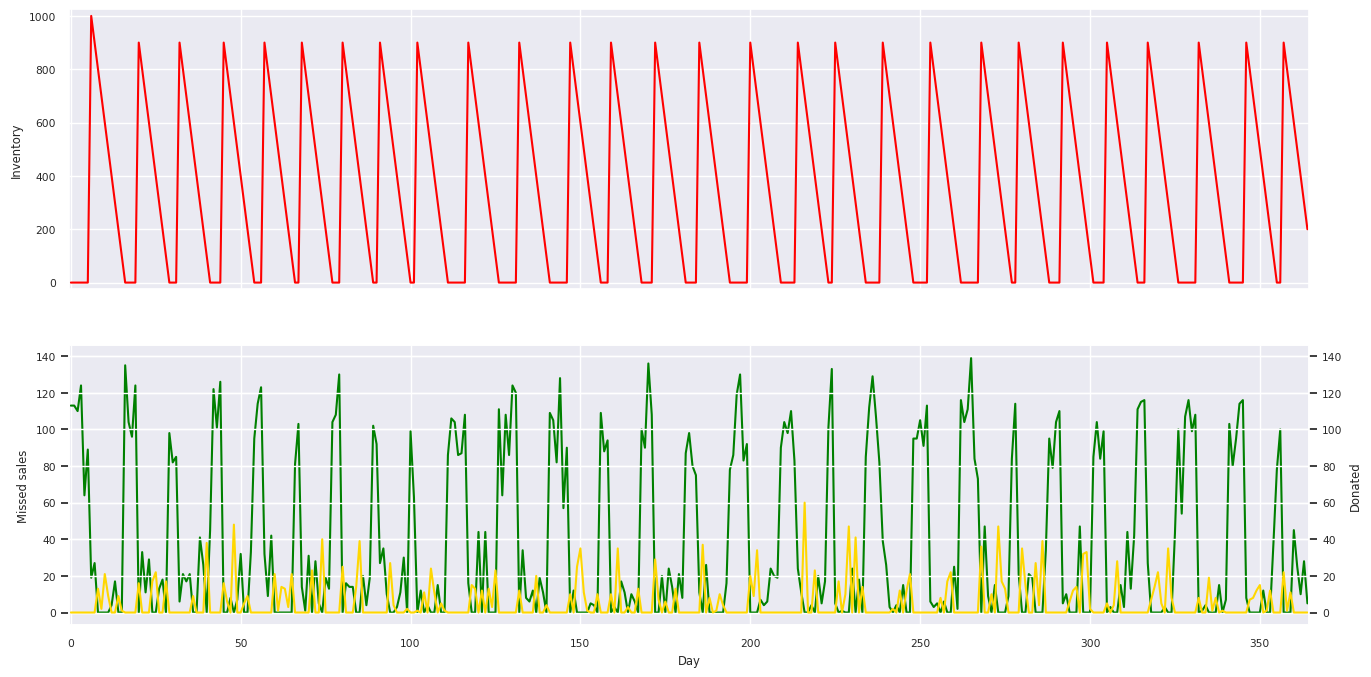

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, sharex = True, figsize = (16, 8), dpi =  100)
l = len(inv)
plt.xlim(-0.5, l - 0.5)
plt.xlabel('Day')
t = [ i for i in range(l) ]

# top panel
top = ax[0]
low = min(inv)
high = max(inv)
margin = 0.05 * (high + low) / 2
top.set_ylim(low - margin, high + margin)
top.plot(t, inv, c = 'red')
top.set_ylabel('Inventory')

# bottom panel
bottom = ax[1]
twin = bottom.twinx()
h = max(max(donated), max(opportunity))
m = 0.05 * h

bottom.set_ylim(-m, h + m)
bottom.plot(t, opportunity, c = 'green')
bottom.set_ylabel('Missed sales')

twin.set_ylim(-m, h + m)
twin.plot(t, donated, c = 'gold')
twin.set_ylabel('Donated')

plt.show()

This should clearly be a subroutine so we could compare different reorder points. We would like to minimize the missed sales, keep an eye on the donations, and maxime our profits.

In [74]:
def assess(reorderPoint, period):
  cost = 0
  income = 0
  inventory = 0 # start with nothing in the freezer
  arrival = None
  order = None

  opp = 0 # just count the lost opportunity
  don = 0 # just count donations

  for day in period:
   if inventory < reorderPoint and arrival is None: # need more and have not yet ordered
     order = freezerCapacity - inventory
     cost += deliveryCost + unitCost * order
     arrival = randint(leadTimeLow, leadTimeHigh)
   baked = min(inventory, ovenCapacity) # either the full oven or whatever is left
   inventory -= baked
   sold = min(day, baked) # cannot sell more than we baked
   don += max(baked - sold, 0)
   opp += max(0, day - baked)
   income += sold * price
   if arrival is not None: # if we are expecting a delivery at the end of the day
     arrival -= 1 # let the days pass
     if arrival == 0: # the arrival is today
       inventory += order # it is here
       assert inventory <= freezerCapacity # make sure we do not violate this
       arrival = None # reset the resupply status
       order = None
  profit = income - cost # if negative, this will be a loss
  return (profit, opp, don) # return our three criteria

In [75]:
replicas = 100 # how many independent simulations to create
data = []

for r in range(replicas):
  year = [ round(d) for d in normal(demandMean, demandSd, duration) ]
  for rp in range(50, freezerCapacity, 50):
    (p, o, d) = assess(rp, year)
    data.append( { 'replica' : r, 'reorderPoint' : rp, 'profit' : p, 'lostSales' : o, 'donations' : d } )

import pandas as pd
results = pd.DataFrame(data)
results

,replica,reorderPoint,profit,lostSales,donations
0,0,50,56526.0,13524,2064
1,0,100,53841.5,14291,2031
2,0,150,56905.0,13050,1890
3,0,200,57230.5,12957,1897
4,0,250,57822.0,12628,1968
...,...,...,...,...,...
1895,99,750,71807.0,6118,2738
1896,99,800,72251.0,5914,2734
1897,99,850,69948.5,6729,2749
1898,99,900,68042.0,7648,2568


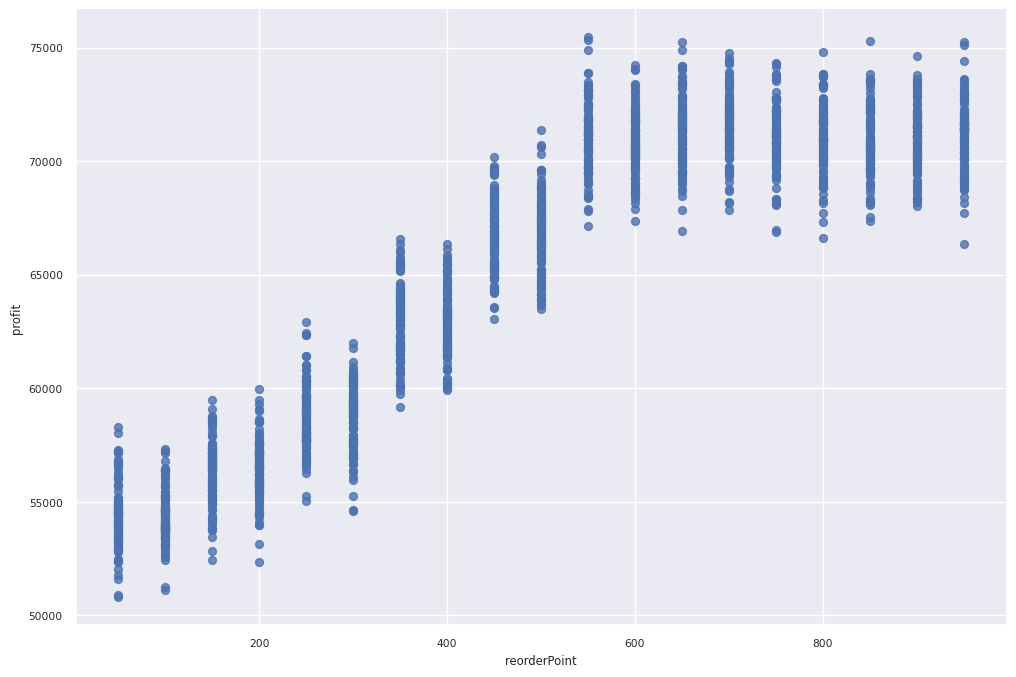

In [76]:
from matplotlib import pyplot as plt
results.plot(kind='scatter', x='reorderPoint', y='profit', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='reorderPoint', ylabel='profit'>

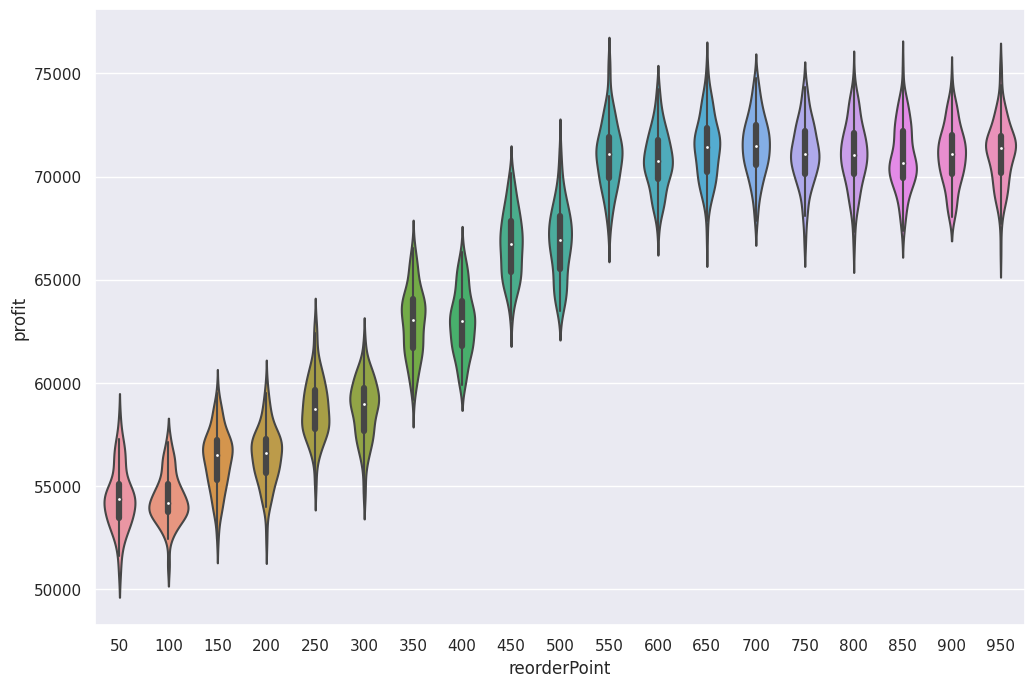

In [77]:
import seaborn as sns
sns.set(rc = {'figure.figsize' : (12, 8)})

#sns.stripplot(data = results, x = 'reorderPoint', y = 'profit', color='gray', alpha=0.5)
sns.violinplot(data = results, x = 'reorderPoint', y = 'profit')

<Axes: xlabel='reorderPoint', ylabel='lostSales'>

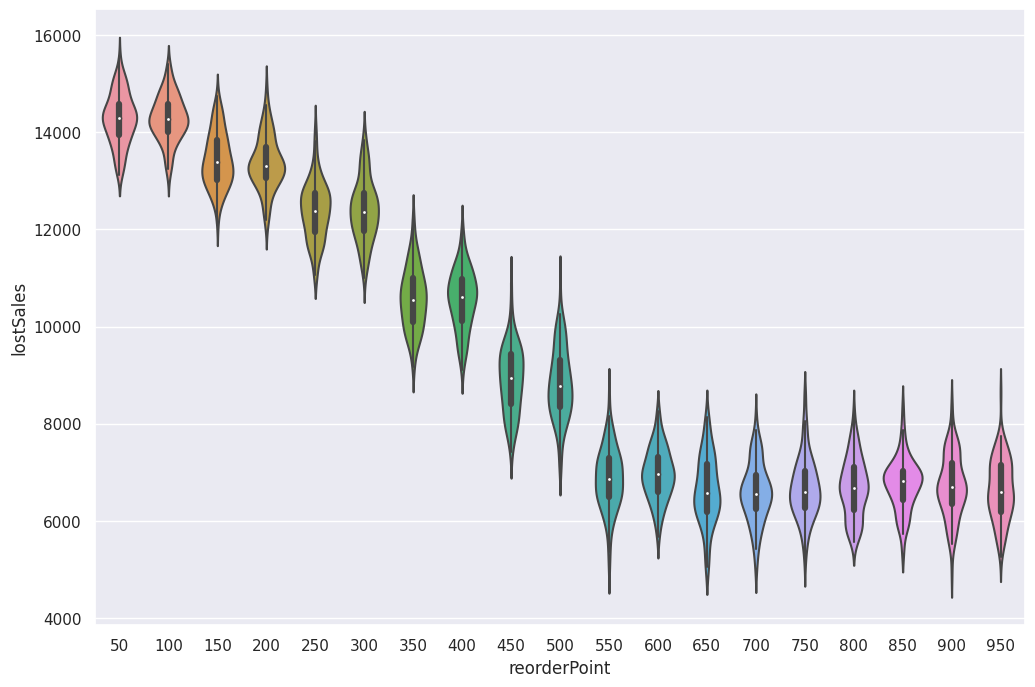

In [78]:
sns.violinplot(data = results, x = 'reorderPoint', y = 'lostSales')

<Axes: xlabel='reorderPoint', ylabel='donations'>

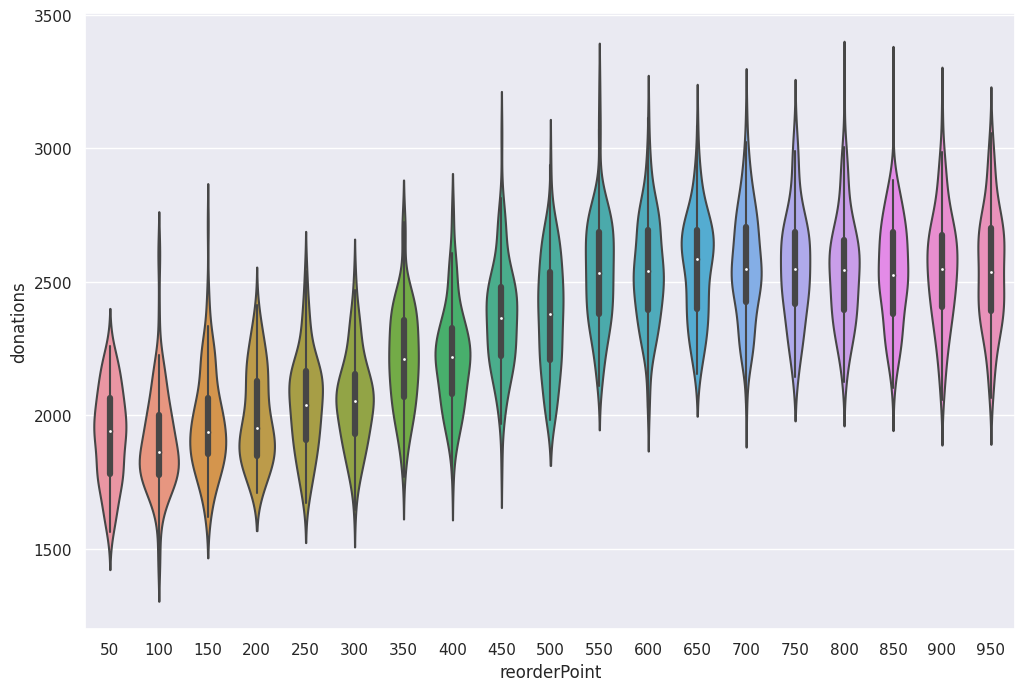

In [79]:
sns.violinplot(data = results, x = 'reorderPoint', y = 'donations')

550 looks good in terms of maximizing profit and minimizing lost sales. The Donations tend to stabilize so maybe our oven is too big. Let's try to figure out how many croissants we should bake, but maintaining the reorder point at a constant 550 now that we have reason to believe it is a good value.

In [81]:
def baking(amount, period, reorderPoint = 550):
  cost, income, inventory = 0, 0, 0
  arrival, order = None, None
  opp, don = 0, 0

  for day in period:
   if inventory < reorderPoint and arrival is None:
     order = freezerCapacity - inventory
     cost += deliveryCost + unitCost * order
     arrival = randint(leadTimeLow, leadTimeHigh)
   baked = min(inventory, min(amount, ovenCapacity)) # <--- NEW LOGIC HERE
   inventory -= baked
   sold = min(day, baked)
   don += max(baked - sold, 0)
   opp += max(0, day - baked)
   income += sold * price
   if arrival is not None:
     arrival -= 1
     if arrival == 0:
       inventory += order
       arrival = None
       order = None
  profit = income - cost
  return (profit, opp, don)

In [89]:
bd = []

for r in range(replicas):
  year = [ round(d) for d in normal(demandMean, demandSd, duration) ] # these will be new "years" since we did not store them above
  for q in range(70, ovenCapacity + 1, 5): # let it reach max capacity
    (p, o, d) = baking(q, year)
    bd.append( { 'replica' : r, 'quantity' : q, 'profit' : p, 'lostSales' : o, 'donations' : d } )

br = pd.DataFrame(bd)
br

,replica,quantity,profit,lostSales,donations
0,0,70,61782.0,11409,192
1,0,75,64358.0,10304,317
2,0,80,68210.5,8764,557
3,0,85,69615.0,7973,831
4,0,90,70480.5,7484,1287
...,...,...,...,...,...
695,99,80,67969.5,8409,639
696,99,85,69188.5,7913,958
697,99,90,71334.5,6923,1403
698,99,95,73678.0,5612,1977


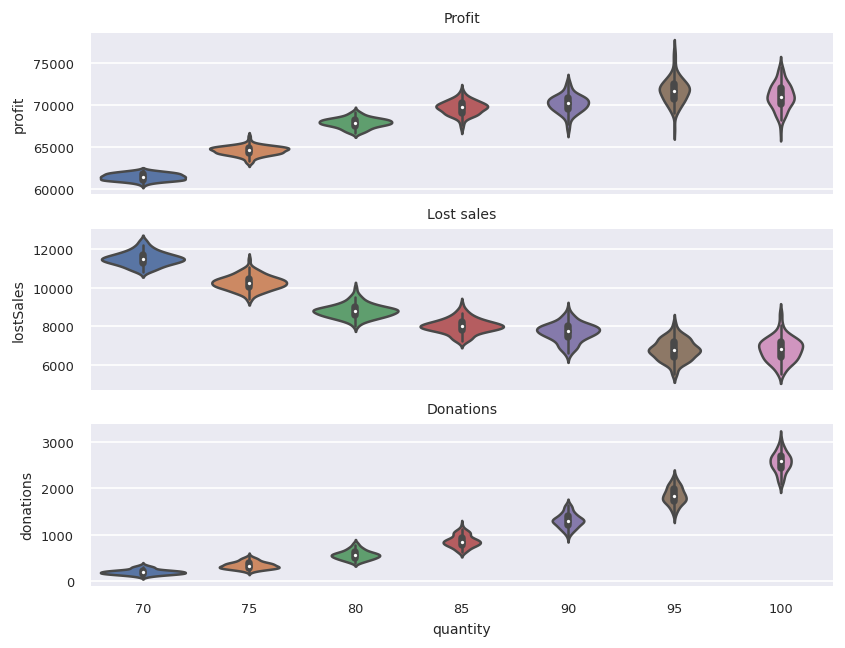

In [90]:
sns.set(font_scale = 0.7)
fig, a = plt.subplots(3, 1, figsize = (8, 6), dpi = 120, sharex = True)

sns.violinplot(ax = a[0], data = br, x = 'quantity', y = 'profit')
a[0].set_title('Profit')
a[0].set_xlabel('')

sns.violinplot(ax = a[1], data = br, x = 'quantity', y = 'lostSales')
a[1].set_title('Lost sales')
a[1].set_xlabel('')

sns.violinplot(ax = a[2], data = br, x = 'quantity', y = 'donations')
a[2].set_title('Donations')

fig.show()

Profits peak below the oven capacity. We have gained more useful information with this second simulated experiment.